In [23]:
import numpy as np
import pandas as pd
import random

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from scipy.special import softmax

from deap import base, creator, tools, algorithms

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, label_binarize
from sklearn.linear_model import Lasso, Ridge, LogisticRegression, SGDClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report
)

from xgboost import XGBClassifier

In [3]:
df = pd.read_csv("X+aki_stage-corr.csv")

target_column = "aki_stage"  # Target variable
df["aki_stage"] = df["aki_stage"].astype("category")
print(df["aki_stage"].dtype)  # Should display "category"
print(df["aki_stage"].unique())  # Display unique categories

def setup_features_and_target(df, target):
    y = df[target]
    X = df.drop(columns=[target], errors='ignore')  # Remove ID column if it exists
    return X, y

X, y = setup_features_and_target(df, target_column)

category
[0, 2, 1, 3]
Categories (4, int64): [0, 1, 2, 3]


In [4]:
# Elastic Net Feature Selection
elastic_net = LogisticRegression(
    penalty='elasticnet',  
    l1_ratio=0.8,         
    solver='saga',
    C=1,             
    max_iter=2000,
    random_state=42
)

elastic_net.fit(X, y)

# Feature Selection
model = SelectFromModel(elastic_net, prefit=True)
selected_features = X.columns[model.get_support()]
X_selected = X[selected_features]

print(f" Number of features selected by Elastic Net: {len(selected_features)}")
print("Selected features: ", selected_features.tolist())

 Number of features selected by Elastic Net: 23
Selected features:  ['gender', 'admission_age', 'sbp_min', 'sbp_max', 'sbp_mean', 'spo2_mean', 'po2_max', 'pco2_min', 'hematocrit_lab_min', 'bicarbonate_lab_min', 'bicarbonate_lab_max', 'calcium_lab_min', 'calcium_lab_max', 'chloride_lab_min', 'chloride_lab_max', 'creatinine_min', 'sodium_lab_max', 'abs_lymphocytes_min', 'gcs_verbal', 'weight_admit', 'race_ASIAN', 'race_NATIVE_AMERICAN', 'race_PACIFIC_ISLANDER']


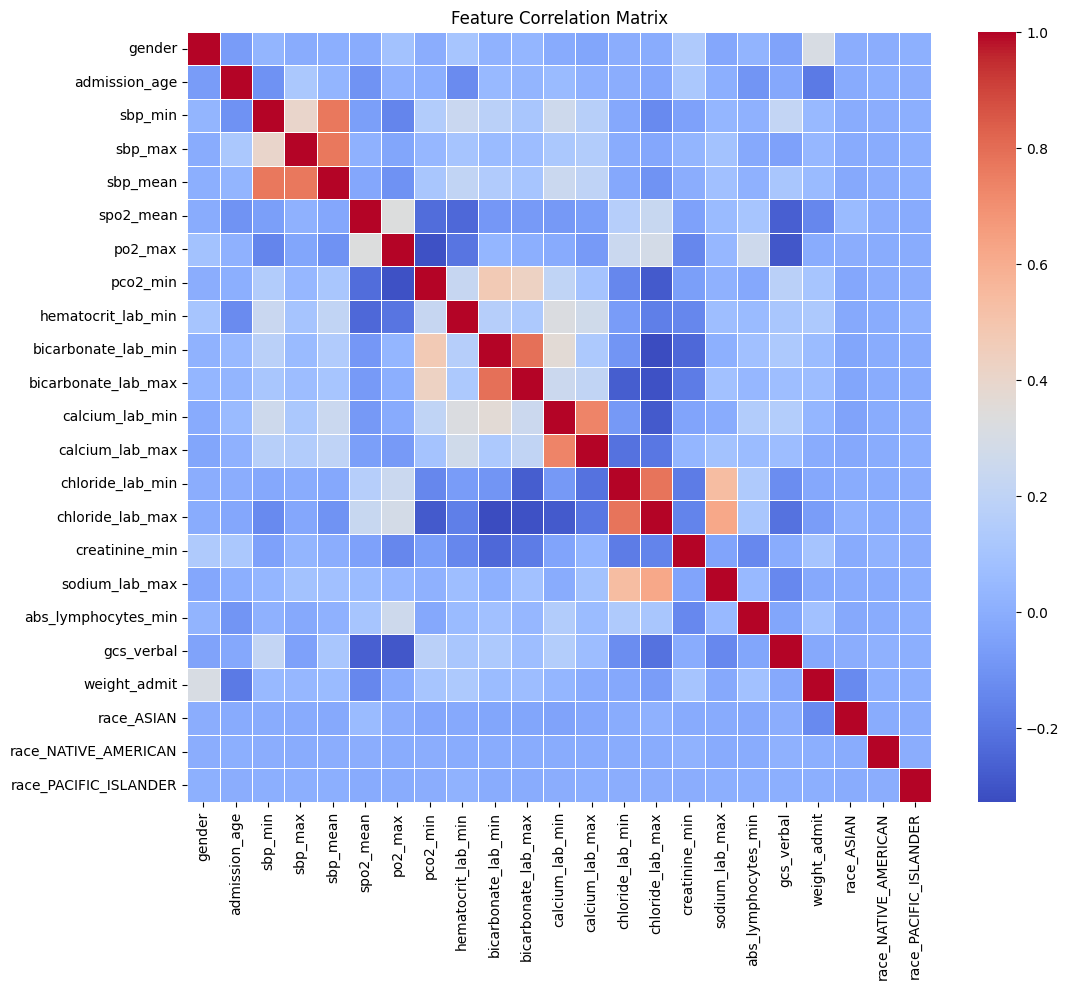

Feature Correlation Matrix (Pearson):

                       gender  admission_age  sbp_min  sbp_max  sbp_mean  \
gender                  1.000         -0.070    0.028   -0.008     0.003   
admission_age          -0.070          1.000   -0.106    0.122     0.030   
sbp_min                 0.028         -0.106    1.000    0.399     0.771   
sbp_max                -0.008          0.122    0.399    1.000     0.770   
sbp_mean                0.003          0.030    0.771    0.770     1.000   
spo2_mean              -0.007         -0.102   -0.058    0.014    -0.031   
po2_max                 0.090          0.011   -0.146   -0.032    -0.105   
pco2_min               -0.004          0.003    0.146    0.039     0.112   
hematocrit_lab_min      0.104         -0.128    0.238    0.101     0.208   
bicarbonate_lab_min     0.018          0.049    0.179    0.055     0.143   
bicarbonate_lab_max     0.034          0.030    0.112    0.063     0.106   
calcium_lab_min        -0.014          0.053    0

In [5]:
# Compute the correlation matrix (default: Pearson correlation coefficient)
correlation_matrix = X_selected.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Print the correlation matrix
print("Feature Correlation Matrix (Pearson):\n")
print(correlation_matrix.round(3))

In [6]:
final_features = [
    'gender', 
    'admission_age', 
    'sbp_mean',            
    'spo2_mean', 
    'po2_max', 
    'pco2_min', 
    'hematocrit_lab_min', 
    'bicarbonate_lab_min',
    'calcium_lab_min', 
    'chloride_lab_min', 
    'creatinine_min', 
    'sodium_lab_max', 
    'abs_lymphocytes_min', 
    'gcs_verbal', 
    'weight_admit', 
    'race_ASIAN'
]

# Correctly reference the defined variable name
X_final_selected = X_selected[final_features]

# Print the number of final selected features
print(f"\n Number of Final Refined Features: {len(final_features)}")
print(" Final Retained Features:", final_features)


 Number of Final Refined Features: 16
 Final Retained Features: ['gender', 'admission_age', 'sbp_mean', 'spo2_mean', 'po2_max', 'pco2_min', 'hematocrit_lab_min', 'bicarbonate_lab_min', 'calcium_lab_min', 'chloride_lab_min', 'creatinine_min', 'sodium_lab_max', 'abs_lymphocytes_min', 'gcs_verbal', 'weight_admit', 'race_ASIAN']


In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_final_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(" Class distribution in y_train:", np.bincount(y_train))
print(" Class distribution in y_test:", np.bincount(y_test))

 Class distribution in y_train: [12994  7670 12690  6110]
 Class distribution in y_test: [3249 1918 3173 1527]


In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from scipy.special import softmax

# Initialize SGDClassifier with logistic regression loss
sgd_clf = SGDClassifier(
    loss='log_loss',        # Logistic regression
    penalty='elasticnet',   # Mixed L1/L2 regularization
    l1_ratio=0.3,
    learning_rate='constant',
    eta0=0.01,
    max_iter=5000,
    random_state=42,
    class_weight='balanced',
    tol=1e-4
)

# Train the model
sgd_clf.fit(X_train, y_train)

# Compute decision function
y_decision = sgd_clf.decision_function(X_test)

# Ensure softmax is applied properly for multi-class probabilities
if y_decision.ndim == 1:
    y_decision = y_decision[:, np.newaxis]  # Reshape if necessary

y_prob = softmax(y_decision, axis=1)

# Predict class labels
y_pred = sgd_clf.predict(X_test)

# One-hot encode y_test for multi-class ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))  # Use all present classes

# Compute multi-class ROC-AUC (One-vs-One)
roc_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovo')

# Model Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Confusion Matrix
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Print Results
print("Multinomial Logistic Regression Evaluation Results:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision (Macro): {precision:.4f}")
print(f" Recall (Macro): {recall:.4f}")
print(f" F1 Score (Macro): {f1:.4f}")
print(f" ROC AUC (OvO): {roc_auc:.4f}")
print("\n Confusion Matrix:\n", conf_matrix)

Multinomial Logistic Regression Evaluation Results:
 Accuracy: 0.4496
 Precision (Macro): 0.4086
 Recall (Macro): 0.4236
 F1 Score (Macro): 0.4067
 ROC AUC (OvO): 0.6829

 Confusion Matrix:
 Predicted     0    1     2    3
Actual                         
0          2214  326   473  236
1           895  265   459  299
2          1062  389  1198  524
3           263  110   395  759


In [17]:
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

# Explicitly specify multi:softprob for multi-class probability prediction
xgb_clf = XGBClassifier(
    objective='multi:softprob',  # Ensures multi-class classification
    num_class=4,  # Specify the number of classes (should match y_train)
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=5, 
    random_state=42
)

# Train the XGBoost model
xgb_clf.fit(X_train, y_train)

# Predict class probabilities
y_prob_xgb = xgb_clf.predict_proba(X_test)

# Predict class labels
y_pred_xgb = np.argmax(y_prob_xgb, axis=1)  # Get class with highest probability

# One-hot encode y_test for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))  

# Compute ROC AUC (multi-class, One-vs-One)
roc_auc_xgb = roc_auc_score(y_test_bin, y_prob_xgb, multi_class='ovo')

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
precision_macro = precision_score(y_test, y_pred_xgb, average='macro')
recall_macro = recall_score(y_test, y_pred_xgb, average='macro')
f1_macro = f1_score(y_test, y_pred_xgb, average='macro')

# Confusion Matrix
conf_matrix_xgb = pd.crosstab(y_test, y_pred_xgb, rownames=['Actual'], colnames=['Predicted'])

# Print Results
print(f"XGBoost ROC AUC (OvO): {roc_auc_xgb:.4f}")
print("\nXGBoost Classification Report (Overall Metrics):")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision (Macro): {precision_macro:.4f}")
print(f" Recall (Macro): {recall_macro:.4f}")
print(f" F1 Score (Macro): {f1_macro:.4f}")
print("\n Confusion Matrix:\n", conf_matrix_xgb)

XGBoost ROC AUC (OvO): 0.7050

XGBoost Classification Report (Overall Metrics):
 Accuracy: 0.4828
 Precision (Macro): 0.4530
 Recall (Macro): 0.4201
 F1 Score (Macro): 0.3951

 Confusion Matrix:
 Predicted     0   1     2    3
Actual                        
0          2200  40   898  111
1           850  54   857  157
2           930  46  1968  229
3           220  26   739  542


In [24]:
# Initialize Decision Tree Classifier
dt_clf = DecisionTreeClassifier(
    criterion='entropy',  # Alternatively, 'gini' can be used
    max_depth=8,  # Control tree depth to prevent overfitting
    random_state=42
)

# Train the model
dt_clf.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_clf.predict(X_test)
y_prob_dt = dt_clf.predict_proba(X_test)  # Predicted probabilities

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
precision_macro = precision_score(y_test, y_pred_xgb, average='macro')
recall_macro = recall_score(y_test, y_pred_xgb, average='macro')
f1_macro = f1_score(y_test, y_pred_xgb, average='macro')

# Confusion Matrix
conf_matrix_xgb = pd.crosstab(y_test, y_pred_xgb, rownames=['Actual'], colnames=['Predicted'])

# Print Results
print(f"XGBoost ROC AUC (OvO): {roc_auc_xgb:.4f}")
print("\nXGBoost Classification Report (Overall Metrics):")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision (Macro): {precision_macro:.4f}")
print(f" Recall (Macro): {recall_macro:.4f}")
print(f" F1 Score (Macro): {f1_macro:.4f}")
print("\n Confusion Matrix:\n", conf_matrix_xgb)

XGBoost ROC AUC (OvO): 0.7050

XGBoost Classification Report (Overall Metrics):
 Accuracy: 0.4828
 Precision (Macro): 0.4530
 Recall (Macro): 0.4201
 F1 Score (Macro): 0.3951

 Confusion Matrix:
 Predicted     0   1     2    3
Actual                        
0          2200  40   898  111
1           850  54   857  157
2           930  46  1968  229
3           220  26   739  542


In [25]:
# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=200,  # Number of trees
    max_depth=5,  # Control tree depth
    random_state=42,
    class_weight='balanced'  # Suitable for imbalanced datasets
)

# Train the model
rf_clf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
precision_macro = precision_score(y_test, y_pred_xgb, average='macro')
recall_macro = recall_score(y_test, y_pred_xgb, average='macro')
f1_macro = f1_score(y_test, y_pred_xgb, average='macro')

# Confusion Matrix
conf_matrix_xgb = pd.crosstab(y_test, y_pred_xgb, rownames=['Actual'], colnames=['Predicted'])

# Print Results
print(f"XGBoost ROC AUC (OvO): {roc_auc_xgb:.4f}")
print("\nXGBoost Classification Report (Overall Metrics):")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision (Macro): {precision_macro:.4f}")
print(f" Recall (Macro): {recall_macro:.4f}")
print(f" F1 Score (Macro): {f1_macro:.4f}")
print("\n Confusion Matrix:\n", conf_matrix_xgb)

XGBoost ROC AUC (OvO): 0.7050

XGBoost Classification Report (Overall Metrics):
 Accuracy: 0.4828
 Precision (Macro): 0.4530
 Recall (Macro): 0.4201
 F1 Score (Macro): 0.3951

 Confusion Matrix:
 Predicted     0   1     2    3
Actual                        
0          2200  40   898  111
1           850  54   857  157
2           930  46  1968  229
3           220  26   739  542


In [26]:
# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=200,  # Number of trees
    max_depth=5,  # Control tree depth
    random_state=42,
    class_weight='balanced'  # Suitable for imbalanced datasets
)

# Train the model
rf_clf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
precision_macro = precision_score(y_test, y_pred_xgb, average='macro')
recall_macro = recall_score(y_test, y_pred_xgb, average='macro')
f1_macro = f1_score(y_test, y_pred_xgb, average='macro')

# Confusion Matrix
conf_matrix_xgb = pd.crosstab(y_test, y_pred_xgb, rownames=['Actual'], colnames=['Predicted'])

# Print Results
print(f"XGBoost ROC AUC (OvO): {roc_auc_xgb:.4f}")
print("\nXGBoost Classification Report (Overall Metrics):")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision (Macro): {precision_macro:.4f}")
print(f" Recall (Macro): {recall_macro:.4f}")
print(f" F1 Score (Macro): {f1_macro:.4f}")
print("\n Confusion Matrix:\n", conf_matrix_xgb)

XGBoost ROC AUC (OvO): 0.7050

XGBoost Classification Report (Overall Metrics):
 Accuracy: 0.4828
 Precision (Macro): 0.4530
 Recall (Macro): 0.4201
 F1 Score (Macro): 0.3951

 Confusion Matrix:
 Predicted     0   1     2    3
Actual                        
0          2200  40   898  111
1           850  54   857  157
2           930  46  1968  229
3           220  26   739  542


In [27]:
# SVM requires feature standardization
svm_clf = make_pipeline(
    StandardScaler(),  # Normalize data
    SVC(
        kernel='rbf',  # Use Radial Basis Function (RBF) kernel
        probability=True,  # Enable probability output
        random_state=42
    )
)

# Train the model
svm_clf.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_clf.predict(X_test)
y_prob_svm = svm_clf.predict_proba(X_test)

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
precision_macro = precision_score(y_test, y_pred_xgb, average='macro')
recall_macro = recall_score(y_test, y_pred_xgb, average='macro')
f1_macro = f1_score(y_test, y_pred_xgb, average='macro')

# Confusion Matrix
conf_matrix_xgb = pd.crosstab(y_test, y_pred_xgb, rownames=['Actual'], colnames=['Predicted'])

# Print Results
print(f"XGBoost ROC AUC (OvO): {roc_auc_xgb:.4f}")
print("\nXGBoost Classification Report (Overall Metrics):")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision (Macro): {precision_macro:.4f}")
print(f" Recall (Macro): {recall_macro:.4f}")
print(f" F1 Score (Macro): {f1_macro:.4f}")
print("\n Confusion Matrix:\n", conf_matrix_xgb)

XGBoost ROC AUC (OvO): 0.7050

XGBoost Classification Report (Overall Metrics):
 Accuracy: 0.4828
 Precision (Macro): 0.4530
 Recall (Macro): 0.4201
 F1 Score (Macro): 0.3951

 Confusion Matrix:
 Predicted     0   1     2    3
Actual                        
0          2200  40   898  111
1           850  54   857  157
2           930  46  1968  229
3           220  26   739  542
